# Matrix multiplication 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_00 import *
import operator

def test(a, b, op):
    assert op(a, b)

def test_eq(a,b): test(a, b, operator.eq)

In [9]:
test_eq(TEST, 'test')

## Get Data

In [3]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [4]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/luan/.fastai/data/mnist.pkl.gz')

In [5]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
# See shape
print(x_train.shape, y_train.shape)
print(type(x_train))

(50000, 784) (50000,)
<class 'numpy.ndarray'>


In [7]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [13]:
assert n==y_train.shape[0]==50000
test_eq(c, 28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'

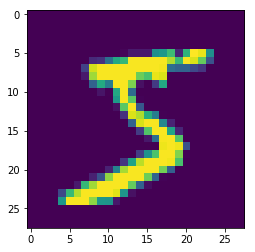

In [18]:
img = x_train[0]
plt.imshow(img.view((28, 28)))  # can use tensor with matplotlib

# Python Model 

In [8]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)    # Why not randn? but zero for bias

In [9]:
def matmul(a,b):
    ar, ac = a.shape # row, col
    br, bc = b.shape
    assert(ac == br)
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i, k] * b[k, j]
    return c

In [10]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [11]:
%time t1 = matmul(m1, m2)

CPU times: user 419 ms, sys: 202 µs, total: 420 ms
Wall time: 437 ms


In [12]:
t1.shape

torch.Size([5, 10])

# Broadcasting

In [13]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [14]:
a + b

tensor([12., 14.,  3.])

In [15]:
(a < b).float().mean()

tensor(0.6667)

In [16]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [17]:
# Sample of frobenius norm
(m*m).sum().sqrt()

tensor(16.8819)

In [18]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [19]:
%time _= matmul(m1, m2)

CPU times: user 1.26 ms, sys: 164 µs, total: 1.42 ms
Wall time: 1.27 ms


In [20]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)

In [22]:
test_near(t1, matmul(m1, m2))

# Broadcasting

In [23]:
a

tensor([10.,  6., -4.])

In [24]:
a > 1

tensor([1, 1, 0], dtype=torch.uint8)

In [25]:
a + 1

tensor([11.,  7., -3.])

In [26]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [27]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

In [29]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [30]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [31]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [33]:
# Explain
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [34]:
c.shape

torch.Size([3])

In [35]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [39]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [41]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [42]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [43]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [44]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

# Matmul with broadcasting

In [45]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        #c[i,j] = (a[i,:] * b[:,j]).sum()
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [47]:
%timeit -n 10 _ = matmul(m1, m2)

213 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
test_near(t1, matmul(m1, m2))

## Rule of broadcasting

In [53]:
c[None, :]; c[None, :].shape

torch.Size([1, 3])

In [54]:
c[:, None].shape

torch.Size([3, 1])

In [55]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [57]:
c[None].shape

torch.Size([1, 3])

In [58]:
# einsum

def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [60]:
%timeit -n 10 _=matmul(m1, m2)

27.7 µs ± 6.39 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
